In [1]:
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import MetaTrader5 as mt
import pandas as pd
from broker_api import BrokerAPI
import backtrader.analyzers as btanalyzers
import pyfolio as pf


C:\Users\codekraft\anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [8]:
# Nossa estratégia de teste
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Buscamos os dados da primeira ação. Como só temos uma (ABEV3), pegamos o indice 0
        self.dataclose = self.datas[0].close

    def next(self):
        # Logamos o preço de fechamento da barra 
        self.log('Close, %.2f' % self.dataclose[0])

        if self.dataclose[0] < self.dataclose[-1]:
            if self.dataclose[-1] < self.dataclose[-2]:
                self.log('ORDEM DE COMPRA CRIADA, %.2f' % self.dataclose[0])
                self.buy(target=30000)

        if self.position.size > 0:
            if self.dataclose[0] > self.dataclose[-1]:
                if self.dataclose[-1] > self.dataclose[-2]:
                    self.log('POSIÇÃO FECHADA, %.2f' % self.dataclose[0])
                    self.close()

In [11]:
cerebro = bt.Cerebro()

# Adicionamos nossa estratégia à engine
cerebro.addstrategy(TestStrategy)

broker = BrokerAPI()
df_stock = broker.get_stock_by_bars(['PETR4'], 400, mt.TIMEFRAME_D1)

df_stock = df_stock.rename(columns={'time':'date', 'real_volume': 'volume'})
df_stock['date'] = pd.to_datetime(df_stock.date)
df_stock = df_stock[['date', 'open', 'high', 'low', 'close', 'volume', 'stock']]
df_stock = df_stock.set_index('date')

data_bt = bt.feeds.PandasData(
    dataname=df_stock
)

# Adicionamos os dados da ação à nossa engine
cerebro.adddata(data_bt)

# Configuramos nosso valor inicial para a estratégia
cerebro.broker.setcash(100000.0)

# Analyzer
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

results = cerebro.run()

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

#cerebro.plot(volume=False)

result = results[0]

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=2875, maxbars=100000, codepage=0, ping_last=23824, community_balance=0.0, retransmission=0.0, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\codekraft\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\codekraft\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 2875, '02 Apr 2021')
Starting Portfolio Value: 100000.00
2019-09-17, Close, 27.17
2019-09-18, Close, 26.71
2019-09-19, Close, 26.78
2019-09-20, Close, 26.49
2019-09-23, Close, 26.97
2019-09-24, Close, 26.76
2019-09-25, Close, 26.83
2019-09-26, Close, 27.18
2019-09-27, Close, 27.14
2019-09-30, Close, 27.03
2019-09-30, ORDEM DE COMPRA CRIADA, 27.03
20

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.02,2020-03-06,2020-03-18,2020-04-22,34
1,0.01,2021-01-12,2021-01-26,2021-02-25,33
2,0.01,2020-09-04,2020-09-29,2020-12-02,64
3,0.01,2020-08-06,2020-08-31,2020-09-01,19
4,0.00,2020-01-06,2020-01-16,2020-02-20,34


C:\Users\codekraft\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\codekraft\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.00%,-0.01%,0.01%


Top 10 long positions of all time,max
Data0,0.18%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data0,0.18%


C:\Users\codekraft\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


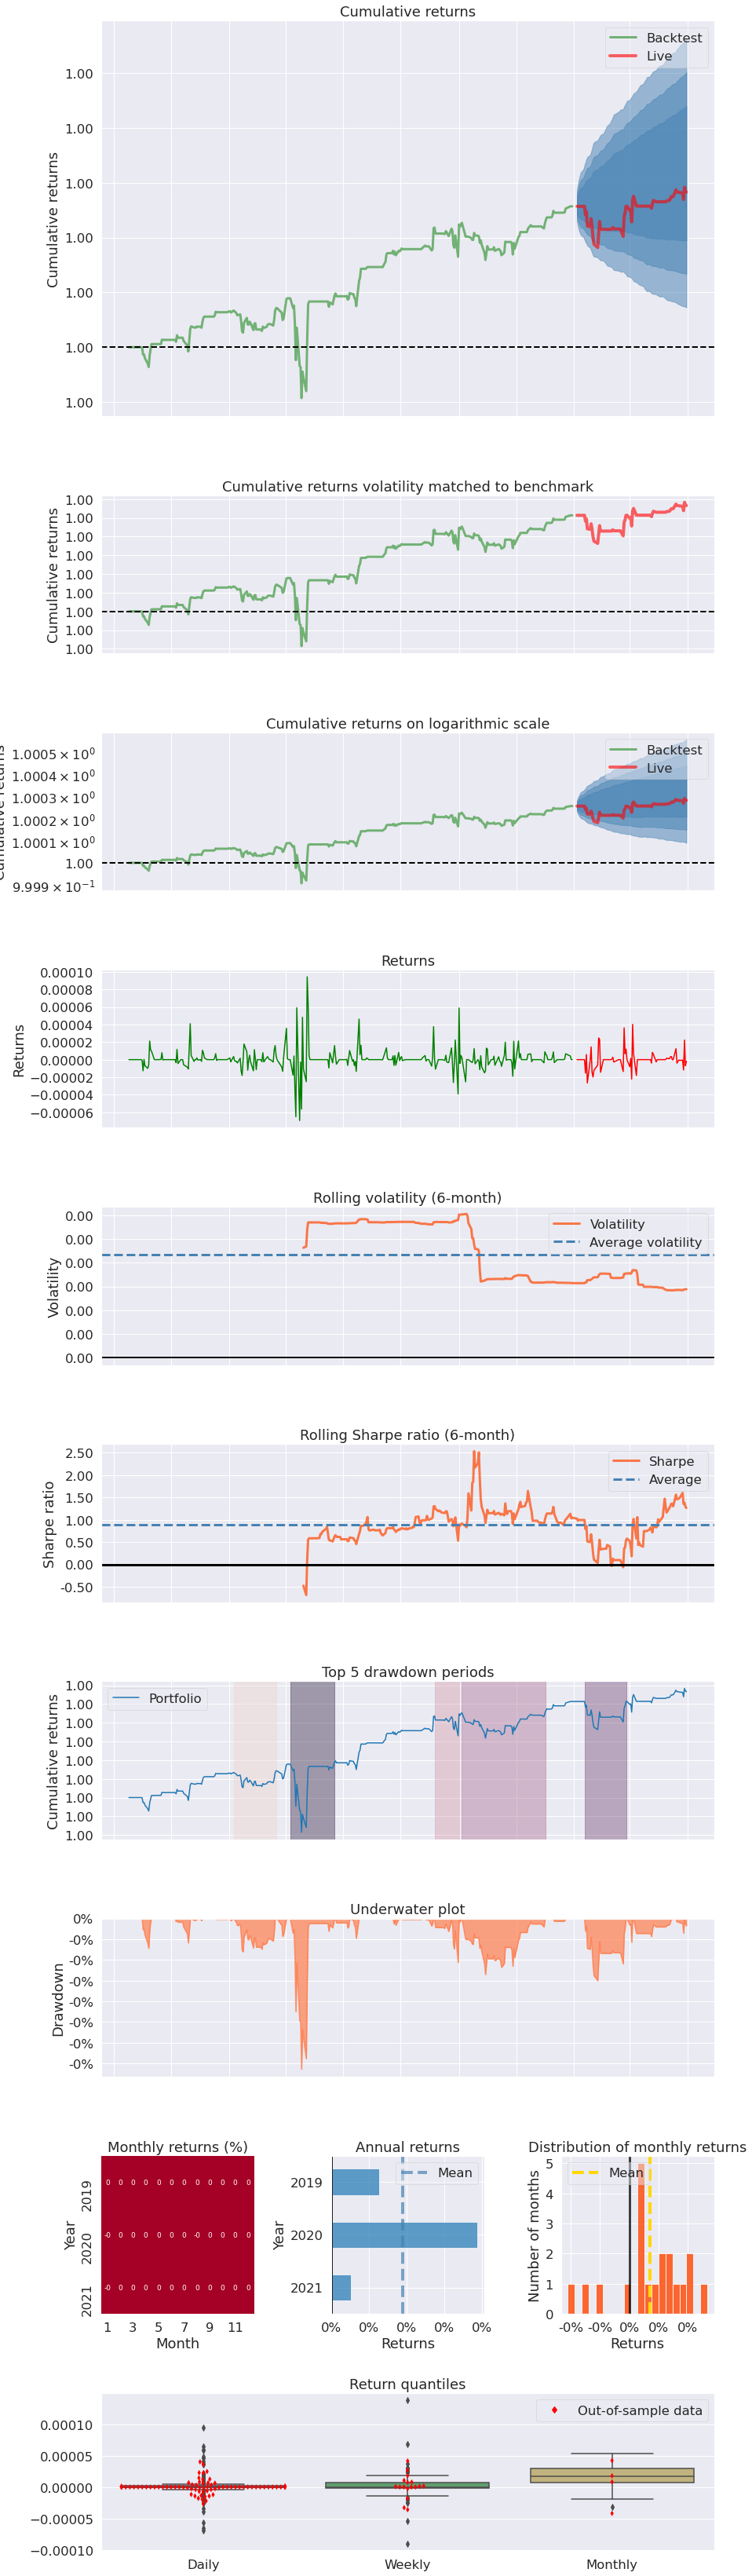

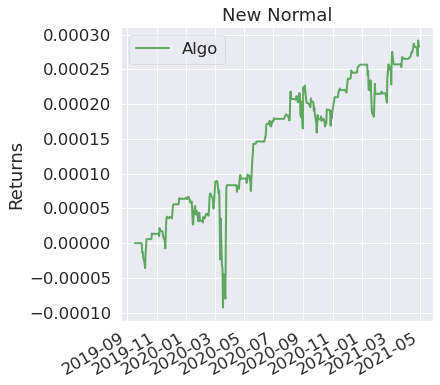

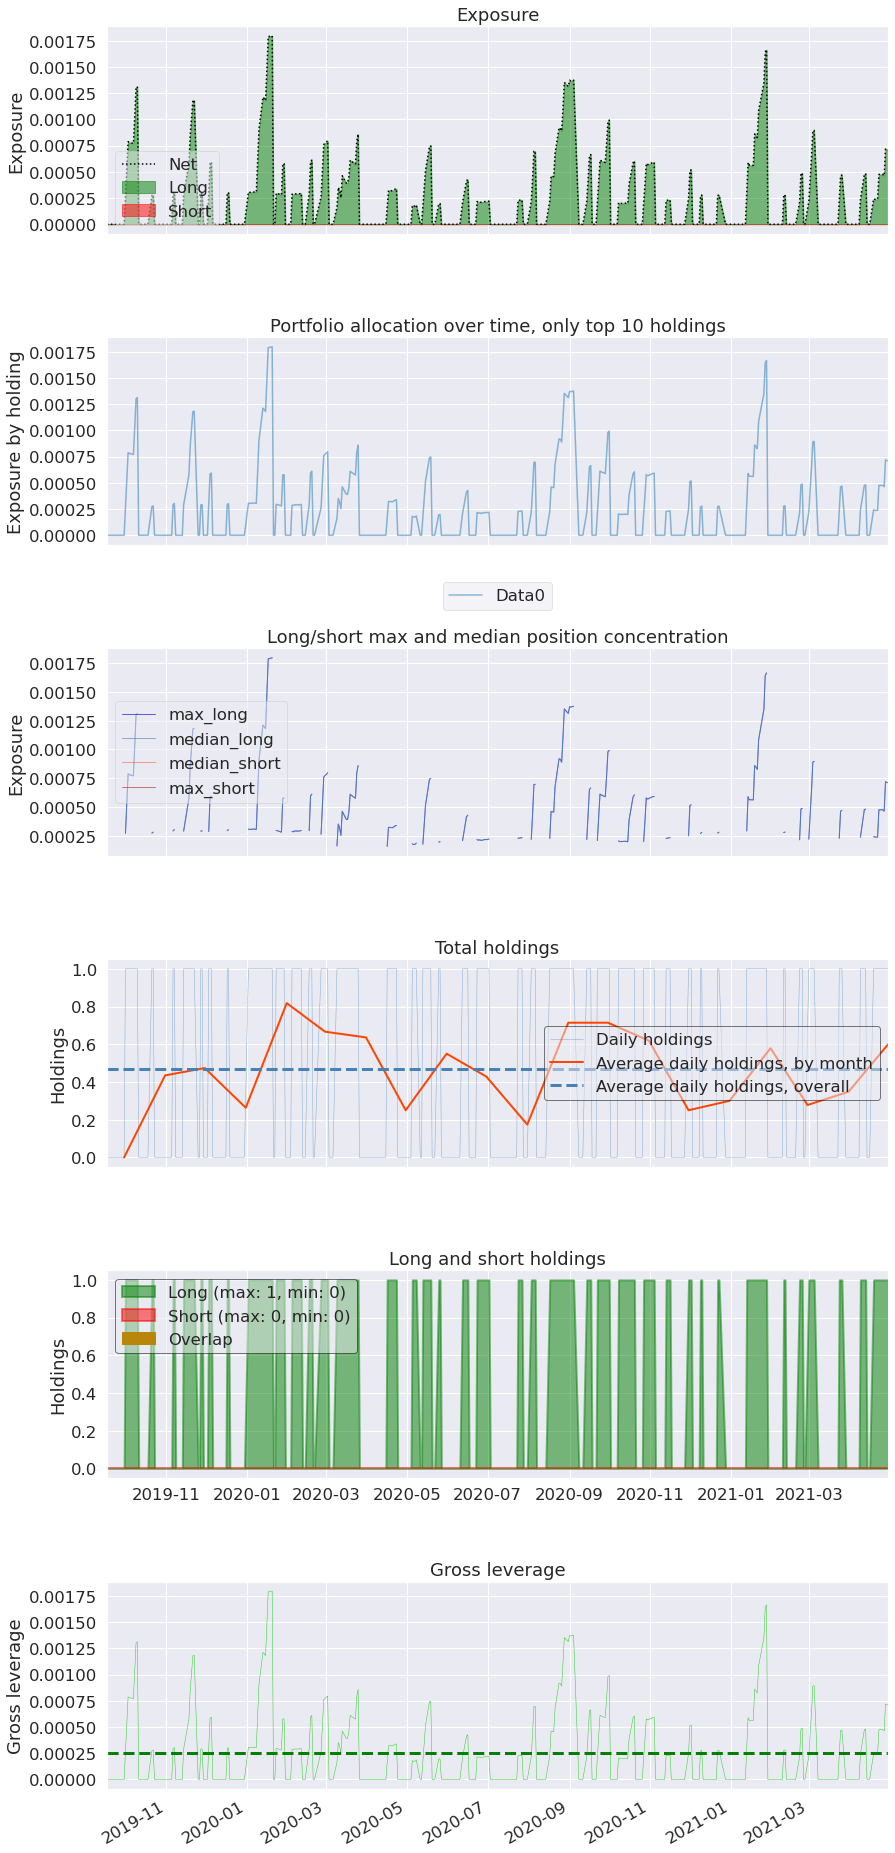

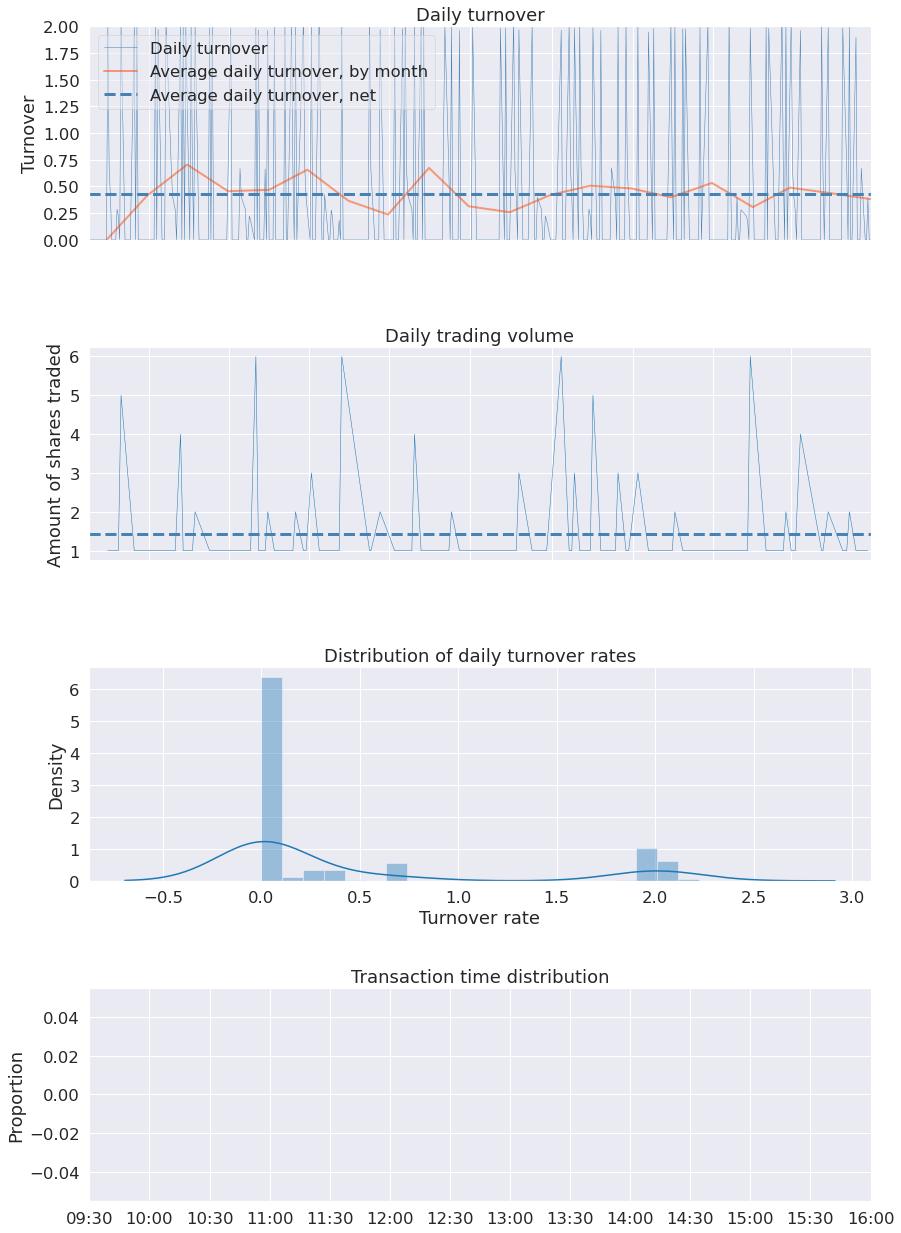

In [13]:
pyfoliozer = result.analyzers.getbyname('pyfolio')

returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()    

pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    live_start_date='2021-01-01'
    )    